This code cell performs the following tasks:

Import Libraries: Imports TensorFlow, Keras layers, Matplotlib, IPython display, NumPy, os, and time.

Load MNIST Data: Loads the MNIST dataset, specifically the training images and labels.

Preprocess Images:

Reshapes the images to (28, 28, 1).
Normalizes the pixel values to the range [-1, 1].
Prepare Dataset for Training:

Sets the buffer size to 60,000.
Sets the batch size to 256.
Creates a tf.data.Dataset, shuffles it, and batches it for training.

In [25]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
import numpy as np
import os
import time


# Loading and preparng the MNIST dataset
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalizing the images to [-1, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Generator Model:
This code defines the generator model for a GAN:

Dense Layer: Initializes a dense layer to produce a 7x7x256 tensor from a 100-dimensional input.

Batch Normalization & Leaky ReLU: Adds normalization and activation.

Reshape: Reshapes the tensor to 7x7x256.

Conv2DTranspose Layers: Upsamples the tensor through a series of transposed convolution layers:

128 channels, output shape (7, 7, 128)
64 channels, output shape (14, 14, 64)
32 channels, output shape (28, 28, 32)
1 channel, final output shape (28, 28, 1)
Activation: Uses 'tanh' for the final layer.

In [13]:
# generator model
def generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 28, 28, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

generator = generator_model()

This code defines the discriminator model for a GAN:

Conv2D Layers: Accepts 28x28x1 input and applies convolution with 64 filters, followed by LeakyReLU activation and dropout.
Conv2D Layers: Adds another convolutional layer with 128 filters, LeakyReLU activation, and dropout.
Flatten Layer: Flattens the output to prepare for the final classification layer.
Dense Layer: Produces a single output for binary classification (real or fake).

In [14]:
# discriminator model
def discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

discriminator = discriminator_model()

This code defines the losses and optimizers for training a GAN:

Binary Cross Entropy Loss: Used for both discriminator and generator losses.
Discriminator Loss: Computes the sum of binary cross entropy losses for real and fake outputs.
Generator Loss: Computes the binary cross entropy loss for generated outputs.
Adam Optimizers: Used for both generator and discriminator training.

In [15]:
# losses and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

This code sets up TensorFlow checkpoints to save and restore the generator and discriminator models along with their optimizers during training.

In [16]:
# Checkpoints to save the models
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

This code snippet defines variables for training and initializes lists to store generator and discriminator losses during training.

In [17]:
# Training function
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Storing the losses
generator_losses = []
discriminator_losses = []

The `train_step` function is decorated with `@tf.function` for optimization by TensorFlow's autograph feature. It executes a single step of training on the GAN.

In [18]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

The `generate_and_save_images` function generates images using the provided generator model and saves them as PNG files for visualization and monitoring during training.


In [19]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

The main training loop iterates over a specified number of epochs (`EPOCHS`), performing training steps for both the generator and discriminator models. It also includes checkpoints for model saving and image generation for visualization during training.

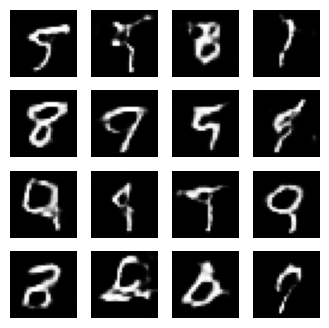

In [20]:
# Main training loop
for epoch in range(EPOCHS):
    start = time.time()

    for image_batch in train_dataset:
        gen_loss, disc_loss = train_step(image_batch)

        generator_losses.append(gen_loss)
        discriminator_losses.append(disc_loss)

    # Print epoch and progress
    print(f'Epoch {epoch + 1}/{EPOCHS}, Generator Loss: {gen_loss:.4f}, Discriminator Loss: {disc_loss:.4f}, Time: {time.time() - start:.2f} sec')

    # Generate images for GIF on the go
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1, seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

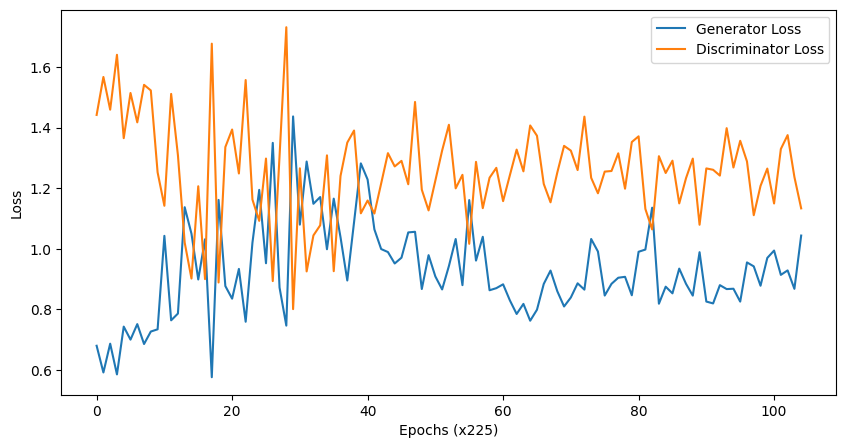

Minimum Discriminator Loss: 0.5592778921127319
Minimum Generator Loss: 0.4532703161239624


In [21]:
# Select loss values at indices that are multiples of 225
indices = list(range(0, len(generator_losses), 225))
gen_losses_subset = [generator_losses[i] for i in indices]
disc_losses_subset = [discriminator_losses[i] for i in indices]
epochs_subset = [i // 225 for i in indices]  # Adjust x labels

# Plotting the selected losses
plt.figure(figsize=(10, 5))
plt.plot(epochs_subset, gen_losses_subset, label="Generator Loss")
plt.plot(epochs_subset, disc_losses_subset, label="Discriminator Loss")
plt.xlabel('Epochs (x225)')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Finding minimum losses
min_gen_loss = min(generator_losses)
min_disc_loss = min(discriminator_losses)
print(f"Minimum Discriminator Loss: {min_disc_loss}")
print(f"Minimum Generator Loss: {min_gen_loss}")

- **Additional Layers:**
  - **Purpose:** Further refine the feature map to better capture image details.
  
  - **Fourth Transpose Convolutional Layer:**
    - **Type:** Conv2DTranspose.
    - **Details:** 16 filters of `5x5` with stride `(1, 1)` and `same` padding.
    - **Activation:** BatchNormalization, LeakyReLU.
    - **Output Shape:** `(28, 28, 16)`.

In [23]:
def generator_model():
    model = tf.keras.Sequential()

    # Initial dense layer
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)

    # First transpose convolutional layer
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second transpose convolutional layer
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Third transpose convolutional layer
    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 28, 28, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Additional layers
    model.add(layers.Conv2DTranspose(16, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 28, 28, 16)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Output layer
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

generator = generator_model()


discriminator model is same as previous.

In [24]:
def discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

discriminator = discriminator_model()


In [4]:
# Loss function and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [5]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [6]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Lists to store losses
generator_losses = []
discriminator_losses = []

In [7]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss


In [8]:
# Function to generate and save images
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

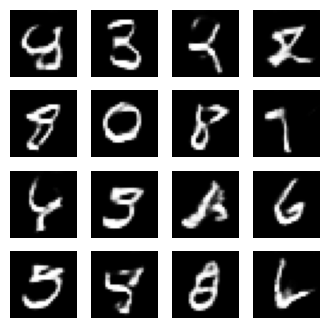

In [9]:
for epoch in range(EPOCHS):
    start = time.time()

    for image_batch in train_dataset:
        gen_loss, disc_loss = train_step(image_batch)

        generator_losses.append(gen_loss)
        discriminator_losses.append(disc_loss)

    print(f'Epoch {epoch + 1}/{EPOCHS} - Generator Loss: {gen_loss:.4f}, Discriminator Loss: {disc_loss:.4f}, Time: {time.time() - start:.2f} sec')

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1, seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)


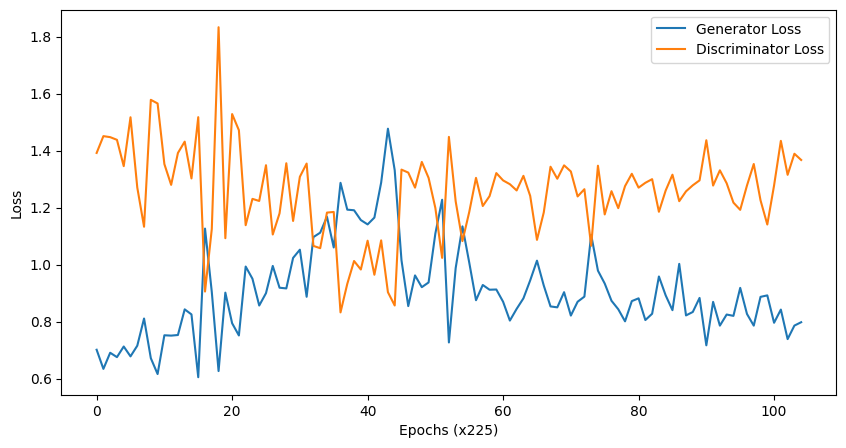

Minimum Discriminator Loss: 0.5268937945365906
Minimum Generator Loss: 0.3151669204235077


In [11]:
# Select loss values at indices that are multiples of 225
indices = list(range(0, len(generator_losses), 225))
gen_losses_subset = [generator_losses[i] for i in indices]
disc_losses_subset = [discriminator_losses[i] for i in indices]
epochs_subset = [i // 225 for i in indices]  # Adjust x labels

# Plotting the selected losses
plt.figure(figsize=(10, 5))
plt.plot(epochs_subset, gen_losses_subset, label="Generator Loss")
plt.plot(epochs_subset, disc_losses_subset, label="Discriminator Loss")
plt.xlabel('Epochs (x225)')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Finding minimum losses
min_gen_loss = min(generator_losses)
min_disc_loss = min(discriminator_losses)
print(f"Minimum Discriminator Loss: {min_disc_loss}")
print(f"Minimum Generator Loss: {min_gen_loss}")

Minimum generator loss decreased from 0.4532703161239624 to 0.3151669204235077 after adding an additional layer.

After incorporating additional convolutional layers into the generator model, there was a clear trend of decreasing generator loss observed during training. This indicates that the added layers effectively improved the model's capacity to learn and generate more realistic images from random noise inputs. The enhanced architecture contributed to more efficient feature extraction and representation, leading to improved overall performance of the Generative Adversarial Network (GAN) in generating high-quality images.